# Deep Learning Inverse Kinematics

In this notebook, you will gain insight into deep learning with PyTorch. You will learn how to solve the inverse transformation for robots, such as the KUKA YouBot, using deep neural networks. You will learn how to build and train such a network with PyTorch.

Helpful links:

- Inverse Recurrent Models - An Application Scenario for Many-Joint Robot Arm Control: https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/kognitive-systeme/projects/inverse-kinematics-with-recurrent-neural-networks/
- Neural Network based Inverse Kinematics Solution for Trajectory Tracking of a Robotic Arm: https://www.sciencedirect.com/science/article/pii/S2212017313006361
- Applying Neural Network to Inverse Kinematic Problem for 6R Robot Manipulator with Offset Wrist: https://www.researchgate.net/publication/227064632_Applying_Neural_Network_to_Inverse_Kinematic_Problem_for_6R_Robot_Manipulator_with_Offset_Wrist
- A Neural Network Approach for Inverse Kinematic of a SCARA Manipulator: https://www.researchgate.net/publication/259198964_A_Neural_Network_Approach_for_Inverse_Kinematic_of_a_SCARA_Manipulator
- PyTorch Doc: https://pytorch.org/docs/stable/index.html

## Idea

We want to perform the inverse transformation for a robot, e.g., the YouBot. This means we need to determine the joint angles that the robot must set to reach a given point in space. This defines the input and output data for the neural network we will create. The network receives the position of the TCP (Tool Center Point) as input and outputs the joint angle positions.

## Data Preparation

One of the most important aspects of supervised learning is the data. In our case, we can easily generate this data. Since we know the forward transformation, we can compute the TCP (Tool Center Point) for any number of joint angle positions.

#### DH Parameter Table youBot

$\begin{array}{rr} \hline
\mathbf{Joint} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

For the forward transformation, we need the DH parameters of the YouBot, which we define as numpy arrays in the following code example.

```python
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])
```

We now write a Python function **dhIthFrame** to create a single DH frame. The parameters are $\theta$, $d$, $a$, and $\alpha$ of the corresponding joint.

```python
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame
```

This DH frame is our blueprint for the forward transformation on the YouBot. We define a Python function **buildDhTcpFrame**, in which we substitute the arguments of such a DH frame with the DH parameters for joint angles $a_{1}$ through $a_{5}$ and accumulate the resulting frames into a result frame.

```python
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame
```

With this function, we now have the ability to calculate the TCP and orientation for given joint angle positions. To create our dataset, we only need the number of joint angle positions.
For this, we consider the joint angle limits of each joint on the YouBot.

$\begin{array}{rr} \hline
\mathbf{Joint} &{Limits°} &{Limits°} \\ \hline
\mathbf{A1} &-169°        &169°  \\ \hline
\mathbf{A2} &-65°         &90°  \\ \hline
\mathbf{A3} &-150°        &146°   \\ \hline
\mathbf{A4} &-102.5°      &102.5°   \\ \hline
\mathbf{A5} &-167.5°      &167.5° \\ \hline
\end{array}$

There are many conceivable ways to generate these joint angles, but this should not be part of this notebook. To keep the notebook clear, some functions have been outsourced. A naive approach would be, for example, randomly generating joint angles. A short code snippet, as found in the class, as an example:
```python
for joint_range in joint_limits:
    joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
    degree_joint_pos.append(joint_val)
degree_joint_pos = np.asarray(degree_joint_pos)
radians = np.radians(degree_joint_pos)     
```

The individual joint angle limits are stored in a list, a random value within these limits is drawn and stored in another list. The values in degrees are finally converted to radians.

For data generation, the DataHandler class is provided. This class requires a robot for initialization. Besides the YouBot (youbot), you can also pass a generic two-axis manipulator (twoaxis) or a Baxter arm (baxter). If you look into the Robot class, you will find that you can also define your own robots by passing DH parameters. The DataHandler class requires no further parameters for creation.

In [1]:
from src.datahandler import DataHandler
from src.robot import Robot

datahandler = DataHandler(robot=Robot(robot='youbot'))

For testing, we generate 5000 joint angle positions and the corresponding TCP frames.

In [2]:
tcp, pos = datahandler(5000, normalize=False)

The dimension of the generated data can be displayed using numpy's shape function. We see that we have an input size of 12 points for our network. This comes from the TCP matrix, where the bottom row is deliberately omitted since it always consists of [0,0,0,1]. As output, the network has the desired 5 joint angle positions.

In [3]:
print("TCP Shape:", tcp.shape)
print("Joint Shape:", pos.shape)

TCP Shape: (5000, 12)
Joint Shape: (5000, 5)


Now we can display some of the TCP frames and verify that they were generated correctly.

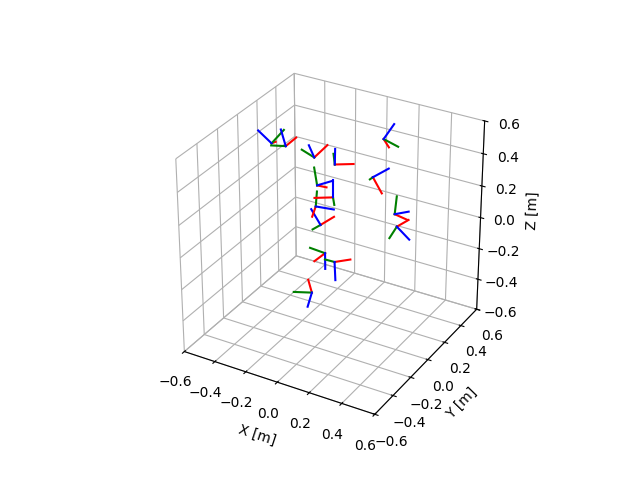

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import plot_basis
from pytransform3d.plot_utils import make_3d_axis

# Konstanten
AXIS_SCALE = 0.6
SAMPLE_SIZE = 15
POINT_SCALE = 1

fig = plt.figure()
ax = make_3d_axis(ax_s=AXIS_SCALE, unit="m", n_ticks=6)

samples = np.random.randint(0, len(tcp), SAMPLE_SIZE)
for i in samples:
    point = tcp[i][3::4] * POINT_SCALE
    rot = np.asarray([tcp[i][0:3], tcp[i][4:7], tcp[i][8:11]])
    plot_basis(ax, R=rot, p=point, s=0.1)

plt.show()

Using scipy's `probplot` function, we can check whether the generated values from the DataHandler follow a uniform distribution. This function creates a probability plot.

A probability plot is a graphical tool for assessing whether a dataset distribution follows a theoretical distribution. It does this by plotting the ordered data values against the expected values of the corresponding quantiles of the chosen theoretical distribution. If the data follows the theoretical distribution, the points in the plot should lie approximately along a straight line.

You will see that this is not the case with 100 values, but as `n` increases, it approaches the line more closely.

Extreme Positions not computed!


/home/nex/Code/DL-inversekinematic/src/datahandler.py:207: UserWarning: Too few samples to generate extreme positions. Either turn off generation of extreme positions or generate more Data. 1024 extreme positions must be generated but you only generate 600 samples.
  warnings.warn(f"Too few samples to generate extreme positions."


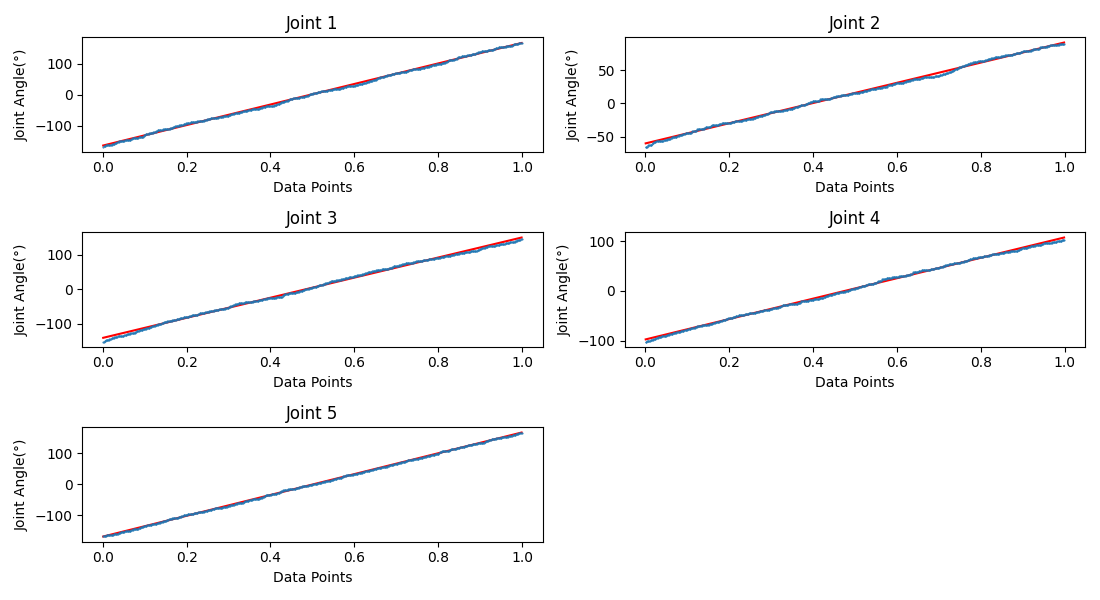

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

n_pos = datahandler.generate_n_positions(n=600)
n_joints = n_pos.shape[1]

n_cols = int(np.ceil(np.sqrt(n_joints)))
n_rows = int(np.ceil(n_joints / n_cols))

fig, axs = plt.subplots(n_cols, n_rows, figsize=(11, 6))
    
axs = axs.flatten()

# remove the extra subplots
for i in range(n_joints, n_rows * n_cols):
    fig.delaxes(axs[i])

for i in range(n_joints):
    (osm, osr), (slope, intercept, r) = stats.probplot(n_pos[:, i], dist="uniform")
    axs[i].plot(osm, slope*osm + intercept, 'r-', markersize=1)    
    axs[i].plot(osm, osr, 'o', markersize=0.5)  # Adjust the markersize here
    axs[i].set_title(f'Joint {i+1}')
    axs[i].set_xlabel('Data Points')
    axs[i].set_ylabel('Joint Angle(°)')
    


plt.tight_layout()
plt.show()

If we've done everything correctly, our data generator is ready and provides us with both the input and output data for the neural network. For training with supervised learning, we need both. The input data (TCP) is propagated through the network, which produces an output (joint angle position). This output is compared with the expected joint angle positions for the TCP, and an error is calculated. Based on this error, the network can adjust its weights using the backpropagation algorithm.

To make it easier for the network, the rotation matrix of the TCP is converted to the special Euler angles roll, pitch, and yaw. This is also handled by the DataHandler class by setting the parameter euler=True. If you want to work with the original TCP data again, set this parameter to False. The DataHandler also needs information about whether the relative TCP should be calculated and whether to work with noisy joint angles to compute the network input shape.

For example, you can convert the output from TCP + rotation matrix to XYZ positions and Euler angles, changing the data shape from 12 to 6:
```python
datahandler.euler = True
```

If you want to change the data generation so that the output changes from (tcp, joint_pos) to (tcp, joint_pos, noised_tcp, noised_joint_positions), you can do this by setting the parameters accordingly. The data shape changes from 12/6 to 29/17 depending on whether Euler angles are used:

```python
datahandler.relative = True
datahandler.noised = True
```

## Understanding Normalization Ranges

The `normrange` parameter controls how data is scaled before feeding it to the network. This choice **must match** the network's output activation function.

### NormRange Options

| Mode | Range | Use When |
|------|-------|----------|
| `NormRange.MINUS_ONE_TO_ONE` | [-1, 1] | Output activation is **Tanh** |
| `NormRange.ZERO_TO_ONE` | [0, 1] | Output activation is **Sigmoid** |

### Why This Matters

- **Tanh** outputs values in [-1, 1]
- **Sigmoid** outputs values in [0, 1]

If the normalization range doesn't match the activation function's range, the network cannot represent the full output space. For example, if your target values are normalized to [-1, 1] but your output layer uses Sigmoid (which outputs [0, 1]), the network can never predict negative values.

**Default Recommendation:** Use `NormRange.MINUS_ONE_TO_ONE` with `output_activation="tanh"` (which is the default configuration).

In [11]:
from src.normrange import NormRange

datahandler.euler = False
datahandler.relative = False
datahandler.noised = False
datahandler.normrange = NormRange.MINUS_ONE_TO_ONE

## Network Architecture

The `src/models` package provides a modular architecture system:

| Function | Purpose |
|----------|---------|
| `create_model(arch, **kwargs)` | Create model by architecture name |
| `list_architectures()` | List available architectures |
| `save_checkpoint(model, path, ...)` | Save model with full config |
| `load_checkpoint(path, device)` | Load and reconstruct model |
| `load_checkpoint_full(path, device)` | Load model with all metadata |

### MLPModel Architecture

The default `mlp` architecture builds a feed-forward network with:
1. Input layer → hidden layers with BatchNorm + GELU activation
2. Output layer with **Tanh** activation (constrains output to [-1, 1])

The Tanh output activation matches `NormRange.MINUS_ONE_TO_ONE`.

In [17]:
import torch
import torch.nn as nn
from src.models import create_model, save_checkpoint, load_checkpoint, list_architectures

print("Available architectures:", list_architectures())

model = create_model(
    "mlp",
    in_features=datahandler.get_input_shape(),
    out_features=datahandler.get_output_shape(),
    neurons=[512, 512, 256, 256, 128],
    activation="gelu",           # Hidden layer activation
    output_activation="tanh",    # Must match normrange!
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
print("\nModel Architecture:")
print(model)

Available architectures: ['mlp']

Using device: cuda

Model Architecture:
MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

### MLP Configuration Options

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| `in_features` | int | required | Input size (use `datahandler.get_input_shape()`) |
| `out_features` | int | required | Output size (use `datahandler.get_output_shape()`) |
| `neurons` | List[int] | required | Hidden layer sizes (e.g., `[512, 256, 128]`) |
| `activation` | str | `"gelu"` | Hidden layer activation: relu, gelu, leaky_relu, elu, selu |
| `output_activation` | str | `"tanh"` | Output activation: tanh, sigmoid, none |
| `use_batchnorm` | bool | `True` | Add BatchNorm after hidden layers |
| `dropout` | float | `0.0` | Dropout rate (0 = disabled) |

**Critical:** The `output_activation` must match the `normrange`:
- `"tanh"` → `NormRange.MINUS_ONE_TO_ONE`
- `"sigmoid"` → `NormRange.ZERO_TO_ONE`

Now we have our training data and our network to be trained. Before we can train it, the learning process must be configured. For this, the optimizer and loss function must be defined.

The loss function determines how the error at the network output is calculated, which is to be minimized. The optimizer is responsible for adjusting the weights in the network. In this case, we use the Adam optimizer and the Mean Squared Error (MSE) as the loss function.

In [18]:
import torch.optim as optim
# For a mean squared error regression problem
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.MSELoss()

model.to(device)
model.train() # Set the model to train mode
print(f"Using device: {device}")

Using device: cuda


PyTorch comes in a CPU and a GPU version. If you're not sure which one is currently running in this notebook, you can print it out beforehand.

In [19]:
print("PyTorch Version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available")
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU not available")

PyTorch Version: 2.10.0+cu128
GPU is available
Device name:  NVIDIA GeForce RTX 3060


If you installed CUDA via Anaconda, you may need to create the file `env-prefix/etc/conda/activate.d/env_vars.sh`:

``` bash
#!/bin/sh

export LD_LIBRARY_PATH="$CONDA_PREFIX/lib"
```

Now we can finally train our model. First, we create a new dataset since 100 examples are not enough to achieve a satisfactory result. At least 100,000 data samples should be generated per epoch.

To start training, we use the <code>Trainer</code> class, which handles the training loop and simplifies the training process. This class takes care of loading the data, training the model, and validation.

Here is the code for initialization and starting the training:

```python
from src.trainer import Trainer

# Set DataHandler to torch, so it generates tensors
datahandler.set_torch(True)
trainer = Trainer(model, optimizer, criterion, device)
trainer.tcp_loss = False
trainer(datahandler, samples=250000, epochs=250, batch_size=1000)
model.eval()
```

In this code, the <code>DataHandler</code> is configured to generate PyTorch tensors. Then a <code>Trainer</code> object is created and configured. The training process is started by calling the <code>__call__</code> method of the <code>Trainer</code> object. The required parameters such as the number of samples (*samples*), the number of epochs (*epochs*), and the batch size (*batch_size*) are passed.

The <code>Trainer</code> class performs the following steps:

**Data Splitting and Loading:** The dataset is split into training and validation data, and DataLoaders are created.

**Training Loop:** For each epoch, the model is trained by propagating input data through the network, calculating the error, and updating the weights.

**Validation:** After each epoch, the model is evaluated to calculate the validation error.

During the training process, the current training and validation losses (*loss* and *val_loss*) are output. The training loss shows how well the model has learned the training data, while the validation loss shows how well the model generalizes to unseen data. A significantly smaller training loss compared to the validation loss indicates overfitting.

In [20]:
from src.trainer import Trainer

# Set DataHandler to torch, so it generates tensors
datahandler.set_torch(True)
trainer = Trainer(model, optimizer, criterion, device)
trainer.tcp_loss = False
trainer(datahandler, samples=1000000, epochs=75, batch_size=512)
model.eval()

Epoch 1/75: 100%|███████████████████████████████████| 1856/1856 [00:09<00:00, 189.07it/s, loss=0.0744]


Epoch 1/75, Train Loss: 0.0759, Val Loss: 0.0690


Epoch 2/75: 100%|███████████████████████████████████| 1856/1856 [00:09<00:00, 188.56it/s, loss=0.0601]


Epoch 2/75, Train Loss: 0.0645, Val Loss: 0.0619


Epoch 3/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 172.30it/s, loss=0.0576]


Epoch 3/75, Train Loss: 0.0621, Val Loss: 0.0611


Epoch 4/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 170.92it/s, loss=0.0732]


Epoch 4/75, Train Loss: 0.0602, Val Loss: 0.0594


Epoch 5/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 167.15it/s, loss=0.0724]


Epoch 5/75, Train Loss: 0.0593, Val Loss: 0.0589


Epoch 6/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 167.16it/s, loss=0.0634]


Epoch 6/75, Train Loss: 0.0584, Val Loss: 0.0580


Epoch 7/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 176.69it/s, loss=0.0577]


Epoch 7/75, Train Loss: 0.0574, Val Loss: 0.0573


Epoch 8/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 168.92it/s, loss=0.0554]


Epoch 8/75, Train Loss: 0.0573, Val Loss: 0.0559


Epoch 9/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 168.14it/s, loss=0.0564]


Epoch 9/75, Train Loss: 0.0567, Val Loss: 0.0560


Epoch 10/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 169.33it/s, loss=0.057]


Epoch 10/75, Train Loss: 0.0565, Val Loss: 0.0566


Epoch 11/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.92it/s, loss=0.0576]


Epoch 11/75, Train Loss: 0.0563, Val Loss: 0.0567


Epoch 12/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 166.23it/s, loss=0.0621]


Epoch 12/75, Train Loss: 0.0559, Val Loss: 0.0554


Epoch 13/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 167.98it/s, loss=0.044]


Epoch 13/75, Train Loss: 0.0557, Val Loss: 0.0545


Epoch 14/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 174.24it/s, loss=0.0466]


Epoch 14/75, Train Loss: 0.0554, Val Loss: 0.0546


Epoch 15/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.84it/s, loss=0.0609]


Epoch 15/75, Train Loss: 0.0555, Val Loss: 0.0546


Epoch 16/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.21it/s, loss=0.0704]


Epoch 16/75, Train Loss: 0.0550, Val Loss: 0.0553


Epoch 17/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 173.55it/s, loss=0.0495]


Epoch 17/75, Train Loss: 0.0552, Val Loss: 0.0544


Epoch 18/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 173.18it/s, loss=0.0517]


Epoch 18/75, Train Loss: 0.0550, Val Loss: 0.0539


Epoch 19/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 166.68it/s, loss=0.0618]


Epoch 19/75, Train Loss: 0.0551, Val Loss: 0.0547


Epoch 20/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.12it/s, loss=0.0674]


Epoch 20/75, Train Loss: 0.0546, Val Loss: 0.0546


Epoch 21/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 164.91it/s, loss=0.054]


Epoch 21/75, Train Loss: 0.0547, Val Loss: 0.0540


Epoch 22/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.63it/s, loss=0.0533]


Epoch 22/75, Train Loss: 0.0545, Val Loss: 0.0548


Epoch 23/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 165.75it/s, loss=0.055]


Epoch 23/75, Train Loss: 0.0543, Val Loss: 0.0540


Epoch 24/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.57it/s, loss=0.0431]


Epoch 24/75, Train Loss: 0.0542, Val Loss: 0.0538


Epoch 25/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 163.08it/s, loss=0.0501]


Epoch 25/75, Train Loss: 0.0539, Val Loss: 0.0539


Epoch 26/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 175.16it/s, loss=0.0629]


Epoch 26/75, Train Loss: 0.0539, Val Loss: 0.0539


Epoch 27/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 179.18it/s, loss=0.0491]


Epoch 27/75, Train Loss: 0.0539, Val Loss: 0.0542


Epoch 28/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 179.31it/s, loss=0.0596]


Epoch 28/75, Train Loss: 0.0536, Val Loss: 0.0546


Epoch 29/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 172.38it/s, loss=0.0565]


Epoch 29/75, Train Loss: 0.0538, Val Loss: 0.0530


Epoch 30/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 175.73it/s, loss=0.0507]


Epoch 30/75, Train Loss: 0.0535, Val Loss: 0.0528


Epoch 31/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 181.57it/s, loss=0.0466]


Epoch 31/75, Train Loss: 0.0537, Val Loss: 0.0539


Epoch 32/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 174.24it/s, loss=0.0553]


Epoch 32/75, Train Loss: 0.0536, Val Loss: 0.0542


Epoch 33/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.60it/s, loss=0.0419]


Epoch 33/75, Train Loss: 0.0533, Val Loss: 0.0524


Epoch 34/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 167.51it/s, loss=0.045]


Epoch 34/75, Train Loss: 0.0533, Val Loss: 0.0533


Epoch 35/75: 100%|███████████████████████████████████| 1856/1856 [00:11<00:00, 167.72it/s, loss=0.049]


Epoch 35/75, Train Loss: 0.0533, Val Loss: 0.0533


Epoch 36/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.19it/s, loss=0.0556]


Epoch 36/75, Train Loss: 0.0531, Val Loss: 0.0529


Epoch 37/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 166.38it/s, loss=0.0612]


Epoch 37/75, Train Loss: 0.0530, Val Loss: 0.0524


Epoch 38/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 169.03it/s, loss=0.0682]


Epoch 38/75, Train Loss: 0.0531, Val Loss: 0.0523


Epoch 39/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.55it/s, loss=0.0549]


Epoch 39/75, Train Loss: 0.0529, Val Loss: 0.0534


Epoch 40/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 164.82it/s, loss=0.0509]


Epoch 40/75, Train Loss: 0.0530, Val Loss: 0.0530


Epoch 41/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 171.18it/s, loss=0.0566]


Epoch 41/75, Train Loss: 0.0531, Val Loss: 0.0528


Epoch 42/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 168.75it/s, loss=0.0528]


Epoch 42/75, Train Loss: 0.0527, Val Loss: 0.0527


Epoch 43/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.56it/s, loss=0.0516]


Epoch 43/75, Train Loss: 0.0526, Val Loss: 0.0536


Epoch 44/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 177.03it/s, loss=0.0499]


Epoch 44/75, Train Loss: 0.0528, Val Loss: 0.0532


Epoch 45/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.83it/s, loss=0.0528]


Epoch 45/75, Train Loss: 0.0529, Val Loss: 0.0532


Epoch 46/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 168.04it/s, loss=0.0544]


Epoch 46/75, Train Loss: 0.0529, Val Loss: 0.0527


Epoch 47/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.32it/s, loss=0.0494]


Epoch 47/75, Train Loss: 0.0528, Val Loss: 0.0529


Epoch 48/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.89it/s, loss=0.0526]


Epoch 48/75, Train Loss: 0.0525, Val Loss: 0.0528


Epoch 49/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 163.78it/s, loss=0.0592]


Epoch 49/75, Train Loss: 0.0526, Val Loss: 0.0535


Epoch 50/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.05it/s, loss=0.0689]


Epoch 50/75, Train Loss: 0.0519, Val Loss: 0.0513


Epoch 51/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.09it/s, loss=0.0393]


Epoch 51/75, Train Loss: 0.0515, Val Loss: 0.0522


Epoch 52/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 169.56it/s, loss=0.0454]


Epoch 52/75, Train Loss: 0.0516, Val Loss: 0.0518


Epoch 53/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.52it/s, loss=0.0555]


Epoch 53/75, Train Loss: 0.0514, Val Loss: 0.0516


Epoch 54/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 168.16it/s, loss=0.0513]


Epoch 54/75, Train Loss: 0.0515, Val Loss: 0.0517


Epoch 55/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 168.30it/s, loss=0.0431]


Epoch 55/75, Train Loss: 0.0515, Val Loss: 0.0527


Epoch 56/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.74it/s, loss=0.0457]


Epoch 56/75, Train Loss: 0.0514, Val Loss: 0.0524


Epoch 57/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 168.02it/s, loss=0.0512]


Epoch 57/75, Train Loss: 0.0514, Val Loss: 0.0516


Epoch 58/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.19it/s, loss=0.0525]


Epoch 58/75, Train Loss: 0.0514, Val Loss: 0.0517


Epoch 59/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 162.34it/s, loss=0.0509]


Epoch 59/75, Train Loss: 0.0515, Val Loss: 0.0509


Epoch 60/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.29it/s, loss=0.0461]


Epoch 60/75, Train Loss: 0.0513, Val Loss: 0.0517


Epoch 61/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.86it/s, loss=0.0494]


Epoch 61/75, Train Loss: 0.0514, Val Loss: 0.0520


Epoch 62/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 171.53it/s, loss=0.0507]


Epoch 62/75, Train Loss: 0.0513, Val Loss: 0.0516


Epoch 63/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 165.18it/s, loss=0.0443]


Epoch 63/75, Train Loss: 0.0513, Val Loss: 0.0511


Epoch 64/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 164.56it/s, loss=0.0543]


Epoch 64/75, Train Loss: 0.0513, Val Loss: 0.0515


Epoch 65/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 170.61it/s, loss=0.0631]


Epoch 65/75, Train Loss: 0.0513, Val Loss: 0.0508


Epoch 66/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 163.89it/s, loss=0.0652]


Epoch 66/75, Train Loss: 0.0511, Val Loss: 0.0523


Epoch 67/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 164.89it/s, loss=0.0487]


Epoch 67/75, Train Loss: 0.0513, Val Loss: 0.0515


Epoch 68/75: 100%|███████████████████████████████████| 1856/1856 [00:10<00:00, 169.72it/s, loss=0.046]


Epoch 68/75, Train Loss: 0.0513, Val Loss: 0.0513


Epoch 69/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 171.08it/s, loss=0.0545]


Epoch 69/75, Train Loss: 0.0513, Val Loss: 0.0516


Epoch 70/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 164.53it/s, loss=0.0428]


Epoch 70/75, Train Loss: 0.0513, Val Loss: 0.0515


Epoch 71/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 167.76it/s, loss=0.0621]


Epoch 71/75, Train Loss: 0.0511, Val Loss: 0.0518


Epoch 72/75: 100%|██████████████████████████████████| 1856/1856 [00:10<00:00, 171.89it/s, loss=0.0562]


Epoch 72/75, Train Loss: 0.0513, Val Loss: 0.0515


Epoch 73/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 164.09it/s, loss=0.0589]


Epoch 73/75, Train Loss: 0.0514, Val Loss: 0.0514


Epoch 74/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 166.05it/s, loss=0.0542]


Epoch 74/75, Train Loss: 0.0512, Val Loss: 0.0515


Epoch 75/75: 100%|██████████████████████████████████| 1856/1856 [00:11<00:00, 166.11it/s, loss=0.0511]


Epoch 75/75, Train Loss: 0.0513, Val Loss: 0.0511


MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): GELU(approximate='none')
    (15): Linear(in_features=128

---

## Model Persistence

Save your trained model using the checkpoint system. The checkpoint format is self-describing and includes:

| Field | Content |
|-------|---------|
| `model_config` | Architecture name + all hyperparameters |
| `state_dict` | Weights + normalization bounds (as buffers) |
| `robot_config` | Robot name and configuration (optional) |
| `training_info` | Epochs, samples, etc. (optional) |

This allows loading models without knowing the original architecture:

```python
# Save after training
save_checkpoint(model, 'model.pt', robot_config={"name": "youbot"})

# Load later (architecture auto-reconstructed)
model = load_checkpoint('model.pt', device=device)
```

In [21]:
# Save model with checkpoint format (includes architecture and normalization bounds)
save_checkpoint(
    model,
    'model_IK.pt',
    robot_config={"name": datahandler.robot.name},
)

In [ ]:
# Load model from checkpoint (automatically reconstructs architecture)
model = load_checkpoint('model_IK.pt', device=device)
model.eval()

---
---

# Evaluation and Inference

**START HERE** if you only want to load a pre-trained model and run inference.

Run the cell below to load a saved model without executing training cells.

### Dual Workflow Support

This notebook supports two workflows:

1. **Full Training**: Run all cells from top to bottom
2. **Inference Only**: Run only the entry point cell below, then continue with evaluation

Both workflows result in properly configured `model` and `datahandler` variables.

In [25]:
# ============================================================
# EVALUATION-ONLY ENTRY POINT
# ============================================================
# Run this cell to load a model and prepare for inference
# without running any training cells above.

import torch
from src.models import load_checkpoint_full
from src.datahandler import DataHandler
from src.robot import Robot

checkpoint_path = 'model_IK.pt'
checkpoint_data = load_checkpoint_full(checkpoint_path,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model = checkpoint_data['model']
model.eval()  # Set to inference mode

# Reconstruct datahandler from model's normalization bounds
robot_name = checkpoint_data['robot_config'].get('name', 'YouBot')
datahandler = DataHandler(robot=Robot(robot=robot_name))

if model.norm_initialized:
    datahandler.set_normalization_bounds(model.get_normalization_bounds())

device = next(model.parameters()).device
print(f"Loaded model for robot: {robot_name}")
print(f"Using device: {device}")
print(f"Normalization initialized: {model.norm_initialized}")

Loaded model for robot: YouBot
Using device: cuda:0
Normalization initialized: True


Now we want to check whether our network also works on new data. To do this, we generate some data again. The generated TCPs serve as input to our model. Via the <code>__call__</code> function, we can propagate our data through the network to get an output. What was not mentioned before is that the data was normalized before being fed into the network. This normalization must be reversed before we can continue working with the data.

### Test Data Generation and Inference

The cell below generates fresh test data, runs inference through the model, and denormalizes the outputs back to radians:

1. **Disable extreme positions** — test data should be purely random to reflect real-world distribution
2. **Forward pass** — normalized TCP is fed through the model to get predicted joint angles
3. **Denormalize** — both ground truth and predictions are converted from normalized space back to radians
4. **Sanity check** — verifies that `norm → denorm` round-trips produce identical values

### Evaluation Metrics

The metrics module (`src.metrics`) computes two categories of error:

- **Joint-space metrics** — MAE and RMSE measure angular error in radians/degrees for each joint. Percentiles (P50, P95, P99) reveal worst-case behavior. Success rate gives the fraction of samples where *all* joints are within 1° or 5° of ground truth.
- **TCP-space metrics** — Position error is the Euclidean distance between where the end-effector actually is vs where it should be, which is the most practically meaningful metric. Orientation error measures rotational deviation via geodesic angle. Success rates report the fraction of samples within 1mm or 5mm.

In [26]:
datahandler.compute_extreme_positions = False
datahandler.set_torch(True)
model.eval()
tcp, gt_joints = datahandler(20000)
pred = model(tcp)
# Denormalize joint positions and TCP and get it off the GPU and back to numpy arrays
gt_pos = datahandler.denorm_joint(gt_joints).cpu().numpy()
pred = datahandler.denorm_joint(pred).cpu().detach().numpy()
datahandler.set_torch(False)

# Sanity Check
import numpy as np

t, j = datahandler(20, normalize=False)
t_norm = datahandler.norm_tcp(t)
t_denorm = datahandler.denorm_tcp(t_norm)
j_norm = datahandler.norm_joint(j)
j_denorm = datahandler.denorm_joint(j_norm)
print("Normalization works: ", np.all([np.all(np.isclose(j, j_denorm)), np.all(np.isclose(t, t_denorm))]))

Normalization works:  True


In [27]:
from src.metrics import compute_all_metrics, format_metrics

metrics = compute_all_metrics(gt_pos, pred, robot=datahandler.robot)
print(format_metrics(metrics))

--- Joint-Space Metrics ---
MAE Total:  0.255725 rad  (14.65 deg)
RMSE Total: 0.515321 rad  (29.53 deg)
Success Rate: <1deg 0.4%  |  <5deg 35.2%

Joint    MAE(deg)  Max(deg)  P50(deg)  P95(deg)  P99(deg)
---------------------------------------------------------
  1         12.85    167.57      1.62     91.23    102.71
  2         11.09    109.04      4.04     41.52     55.52
  3         20.01    266.86      4.39     89.38    127.03
  4         16.27    169.38      5.69     61.52     83.78
  5         13.04    169.46      1.81     91.20    103.33

--- TCP-Space Metrics ---
Position Error:  mean 43.26 mm  |  median 16.81 mm  |  max 502.14 mm
                 P95 192.42 mm  |  P99 320.76 mm
Orientation Error: mean 16.64 deg  |  max 179.98 deg
Success Rate: <1mm 0.2%  |  <5mm 8.9%


We can now display the robot positions for *Ground Truth* and *Prediction* of the joint angle positions for individual values. Orange represents the *Ground Truth* and green the *Prediction*, giving us a graphical representation of what our network has learned.

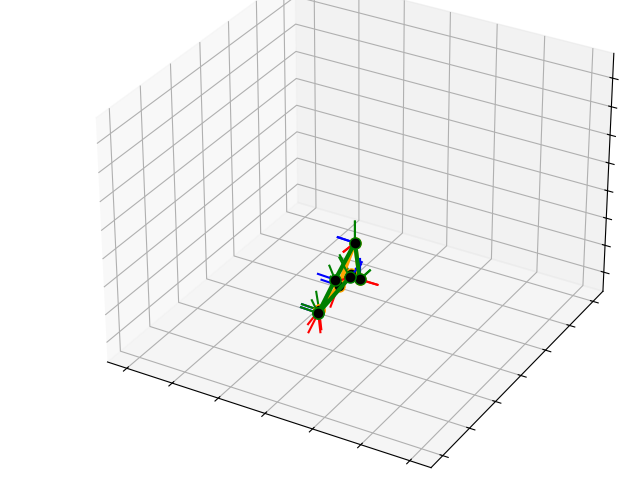

In [28]:
%matplotlib widget
from src.robot_animation import RobotAnimation

drawer = RobotAnimation(datahandler.robot)
#Nummer des Datensatzes
t = 1
drawer.draw_robot([gt_pos[t], pred[t]])

### Trajectory Selection

To evaluate how well the network predicts joint angles for a sequence of TCP positions, we generate trajectories using the `src.trajectories` module.

**Available trajectories:**
| Name | Description | Joints Affected |
|------|-------------|-----------------|
| `circle` | Sweep joint 1 from max to min | Joint 1 only |
| `wave` | Sinusoidal motion with phase offset | All joints |
| `reach` | Extend arm outward then retract | Joints 2-3 |
| `spiral` | Combined rotation + reach | Joints 1 + 2-3 |
| `random_smooth` | Random waypoints with cubic interpolation | All joints |
| `figure_eight` | Figure-8 pattern in joint space | Joints 1-2 |
| `square` | Square pattern with sharp 90° corners | Joints 1-2 |
| `pringles` | True pringles with 90° phase shift | Joints 1-2 |

Change `trajectory_type` in the cell below to try different trajectories.

In [14]:
from src.trajectories import list_trajectories, get_trajectory

# List available trajectories
print("Available trajectories:", list_trajectories())

# Select trajectory type
trajectory_type = "circle"  # Change this to try different trajectories
n_frames = 60

# Generate trajectory (returns radians)
arr = get_trajectory(
    name=trajectory_type,
    robot=datahandler.robot,
    n_frames=n_frames,
)

print(f"\nGenerated '{trajectory_type}' trajectory: {arr.shape}")

Available trajectories: ['circle', 'wave', 'reach', 'spiral', 'random_smooth', 'figure_eight', 'square', 'pringles']

Generated 'circle' trajectory: (60, 5)


The generated joint angle vector can be passed to the <code>draw_trajectory()</code> function of the Drawer class to display an animated trajectory with matplotlib.

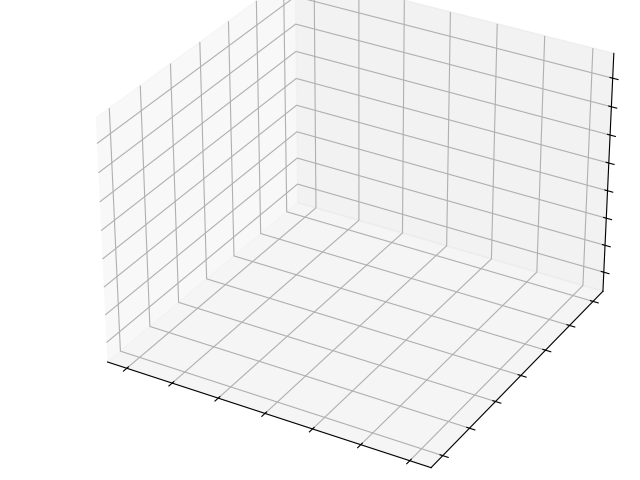

In [15]:
%matplotlib widget

drawer = RobotAnimation(robot=datahandler.robot)

drawer.draw_trajectory_robot(arr)

### Trajectory Inference Loop

The cell below runs frame-by-frame inference on the generated trajectory:

1. **FK computation** — converts ground-truth joint angles to TCP frames via forward kinematics
2. **Normalization** — TCP frames are normalized to match the model's expected input range
3. **Frame-by-frame prediction** — each normalized TCP is fed through the model individually, producing predicted joint angles
4. **Mode handling** — in standard mode (non-relative, non-noised), only the TCP is used as input; in relative/noised mode, the previous joint position and both old and new TCP are concatenated as input
5. **Denormalization** — each predicted output is converted back to radians and appended to the trajectory array

In [16]:
datahandler.set_torch(False)
arr_tcp = datahandler.get_tcp(arr)
arr_tcp = datahandler.norm_tcp(arr_tcp)

#Start positions and TCP
start_rad = np.array([arr[0]])
old_jpos = datahandler.norm_joint(start_rad)
old_tcp = arr_tcp[0]
old_jpos = old_jpos[0]
    
trajectory = []
trajectory.append(start_rad)
#trajectory.append(datahandler.denorm_joint(np.radians([old_jpos])))
for i, tcp in enumerate(arr_tcp):
    #delta_tcp = np.subtract(tcp, old_tcp)
    #input_ = np.expand_dims(np.concatenate((old_jpos, old_tcp, tcp)), axis=0)
    input_ = torch.tensor(tcp, dtype=torch.float32).to(device)
    input_jpos = torch.tensor(old_jpos, dtype=torch.float32).to(device)
    input_tcp = torch.tensor(old_tcp, dtype=torch.float32).to(device)
    if not datahandler.relative and not datahandler.noised:
        in_ = torch.unsqueeze(input_tcp, 0)
    else:
        in_ = torch.unsqueeze(torch.cat((input_jpos, input_tcp, input_)), 0)
    
    output = model(in_).cpu().detach().numpy()
    old_jpos = output[0]
    old_tcp = tcp
    trajectory.append(datahandler.denorm_joint(output))
trajectory = np.squeeze(trajectory, 1)

Finally, we can run the generated joint angle positions as a trajectory again and get a visual comparison between target and actual.

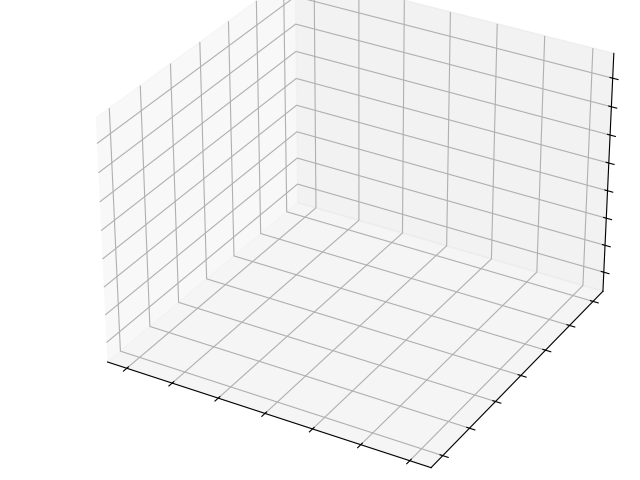

In [17]:
%matplotlib widget
drawer2 = RobotAnimation(robot=datahandler.robot)

drawer2.draw_trajectory_robot(trajectory)